In [1]:
from utils import CustomDataset, TestingDataset
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from resnet_model_multichan_pool import  ResidualBlock, ResNet
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
num_gpus = torch.cuda.device_count()
print(num_gpus)

6


In [2]:
model = ResNet(3, ResidualBlock, [3, 4, 6, 3], num_classes=2).to(device)
model = nn.DataParallel(model).to(device)

model.load_state_dict(torch.load('models/model-78-99.655.pt'))
# model.training = False
model = model.eval()

In [3]:
from copy import deepcopy
def transform(data):
    # integrated = np.mean(data, axis = 0)
    rms = np.std(data)
    mean = np.mean(data)
    masks_rms = [-1, 5]
    new_data = np.zeros((len(masks_rms)+1, data.shape[0], data.shape[1]))
    new_data[0,:,:] = data
    shift = new_data[0,:,:] - new_data[0,:,:].min()
    new_data[0,:,:] = shift/shift.max()
    for i in range(1, len(masks_rms)+1):
        scale = masks_rms[i-1]
        copy_data = deepcopy(data)
        if scale <0:
            ind = data < abs(scale) * rms  + mean
            copy_data[ind] = abs(scale) * rms  + mean # masked out to the bottom noise
        else:
            ind = data > (scale) * rms + mean
            copy_data[ind] = rms + mean # masked out be noise
        # copy_data = np.log10(copy_data-copy_data.min()+1e-10)
        mean = np.mean(copy_data)
        std_dev = np.std(copy_data)
        shift = copy_data - copy_data.min()
        normalized_data = shift / shift.max()
        new_data[i,:,:] = normalized_data       
    new_data = new_data
    new_data = new_data.astype(np.float32)
    return new_data

In [4]:
# Create custom dataset instance
test_data_dir = '/mnt/buf0/pma/frbnn/test_ready'
test_dataset = TestingDataset(test_data_dir, transform=transform)
# test_dataset = CustomDataset(test_data_dir, transform=transform)

testloader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=32)

num_classes = 2


In [5]:
dm_ranges = np.linspace(5, 1000, 10)
snr_ranges = np.linspace(5, 100, 20)
freq_ranges = np.linspace(0, 2157.7199, 100)

In [6]:
from tqdm import tqdm
# eval
model.training
val_loss = 0.0
correct_valid = 0
total = 0
results = {'pred': [], 'true':[], 'freq':[], 'snr':[], 'dm':[]}
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        inputs, labels = images.to(device), labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        results['pred'].extend(predicted.cpu().numpy().tolist())
        results['true'].extend(labels[0].cpu().numpy().tolist())
        results['freq'].extend(labels[2].cpu().numpy().tolist())
        results['dm'].extend(labels[1].cpu().numpy().tolist())
        results['snr'].extend(labels[3].cpu().numpy().tolist())
        total += labels[0].size(0)
        correct_valid += (predicted.cpu() == labels[0].cpu()).sum().item()
    
# Calculate training accuracy after each epoch
val_accuracy = correct_valid / total * 100.0
print("===========================")
print('accuracy: ',  val_accuracy)
print("===========================")

accuracy:  99.4


In [7]:
inputs.shape

torch.Size([32, 3, 192, 2048])

0
freq  1529.0
dm  0.0
snr  0.0


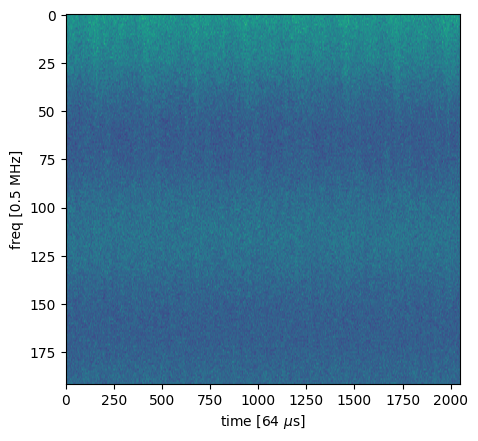

In [8]:
import matplotlib.pyplot as plt
idn = 20
# plt.imshow(np.log10(inputs[idn,0,:,:].cpu().numpy()), aspect = 10)
plt.imshow(inputs[idn,0,:,:].cpu().numpy(), aspect = 10)
plt.xlabel('time [64 $\mu$s]')
plt.ylabel('freq [0.5 MHz]')
print(labels[0].cpu().numpy().tolist()[idn])
print('freq ',labels[2].cpu().numpy().tolist()[idn])
print('dm ',labels[1].cpu().numpy().tolist()[idn])
print('snr ',labels[3].cpu().numpy().tolist()[idn])

In [9]:
recall_matrix = np.zeros((dm_ranges.shape[0]-1,snr_ranges.shape[0]-1))
for i in range(1, dm_ranges.shape[0]):
    for j in range(1, snr_ranges.shape[0]):
        end_dm = dm_ranges[i]
        start_dm = dm_ranges[i-1]

        start_snr = snr_ranges[j-1]
        end_snr = snr_ranges[j]
    
        dm_index = set(np.where( np.logical_and(end_dm > np.array(results['dm']), start_dm<np.array(results['dm'])))[0].tolist())
        snr_index = set(np.where( np.logical_and(end_snr > results['snr'], start_snr< results['snr']))[0].tolist())
        label_index = set(np.where(1 == np.array(results['true']))[0].tolist())

        filtered = (np.array(list(dm_index & snr_index & label_index )),) 
        pred = np.mean(np.array(results['pred'])[filtered])
        recall_matrix[i-1,j-1] = pred * 100

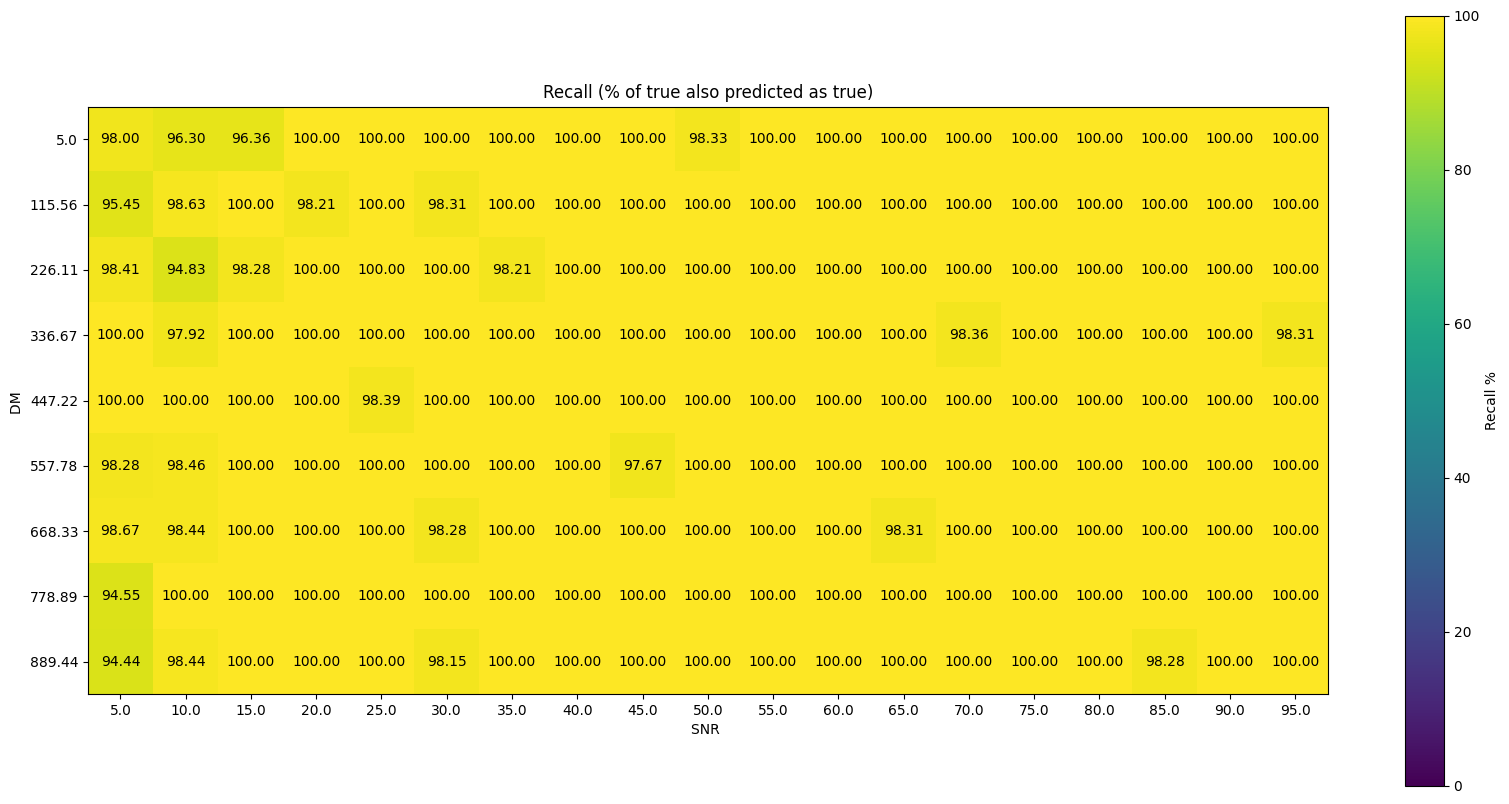

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(recall_matrix, interpolation='nearest', vmin=0, vmax=100)

# Add text annotations to each cell
for i in range(recall_matrix.shape[0]):
    for j in range(recall_matrix.shape[1]):
        plt.text(j, i, f'{recall_matrix[i, j]:.2f}', ha='center', va='center', color='black')

plt.colorbar( label='Recall %')
plt.xlabel('SNR ')
plt.ylabel('DM ')

xtick_positions = np.arange(0, recall_matrix.shape[1], 1)  # Custom x tick positions
ytick_positions = np.arange(0, recall_matrix.shape[0], 1)  # Custom y tick positions
xtick_labels    =  snr_ranges[:-1]# Custom x tick labels
for i in range(len(xtick_labels)):
    xtick_labels[i] = round(xtick_labels[i], 2)

ytick_labels = dm_ranges[:-1]  # Custom y tick labels
for i in range(len(ytick_labels)):
    ytick_labels[i] = round(ytick_labels[i], 2)


plt.xticks(ticks=xtick_positions, labels=xtick_labels)
plt.yticks(ticks=ytick_positions, labels=ytick_labels)

plt.title('Recall (% of true also predicted as true)')
plt.savefig("recall_dm_snr.pdf", format='pdf')

In [11]:
false_negative = np.zeros((dm_ranges.shape[0]-1,snr_ranges.shape[0]-1))
for i in range(1, dm_ranges.shape[0]):
    for j in range(1, snr_ranges.shape[0]):
        end_dm = dm_ranges[i]
        start_dm = dm_ranges[i-1]

        start_snr = snr_ranges[j-1]
        end_snr = snr_ranges[j]
    
        dm_index = set(np.where( np.logical_and(end_dm >np.array(results['dm']), start_dm<np.array(results['dm'])))[0].tolist())
        snr_index = set(np.where( np.logical_and(end_snr >results['snr'], start_snr< results['snr']))[0].tolist())
        label_index = set(np.where(1 == np.array(results['true']))[0].tolist())

        filtered = (np.array(list(dm_index & snr_index )),) 
        pred = np.where(np.array(results['pred'])[filtered] == 0)[0].shape[0] / np.array(results['pred'])[filtered].shape[0]
        recall_matrix[i-1,j-1] = pred * 100

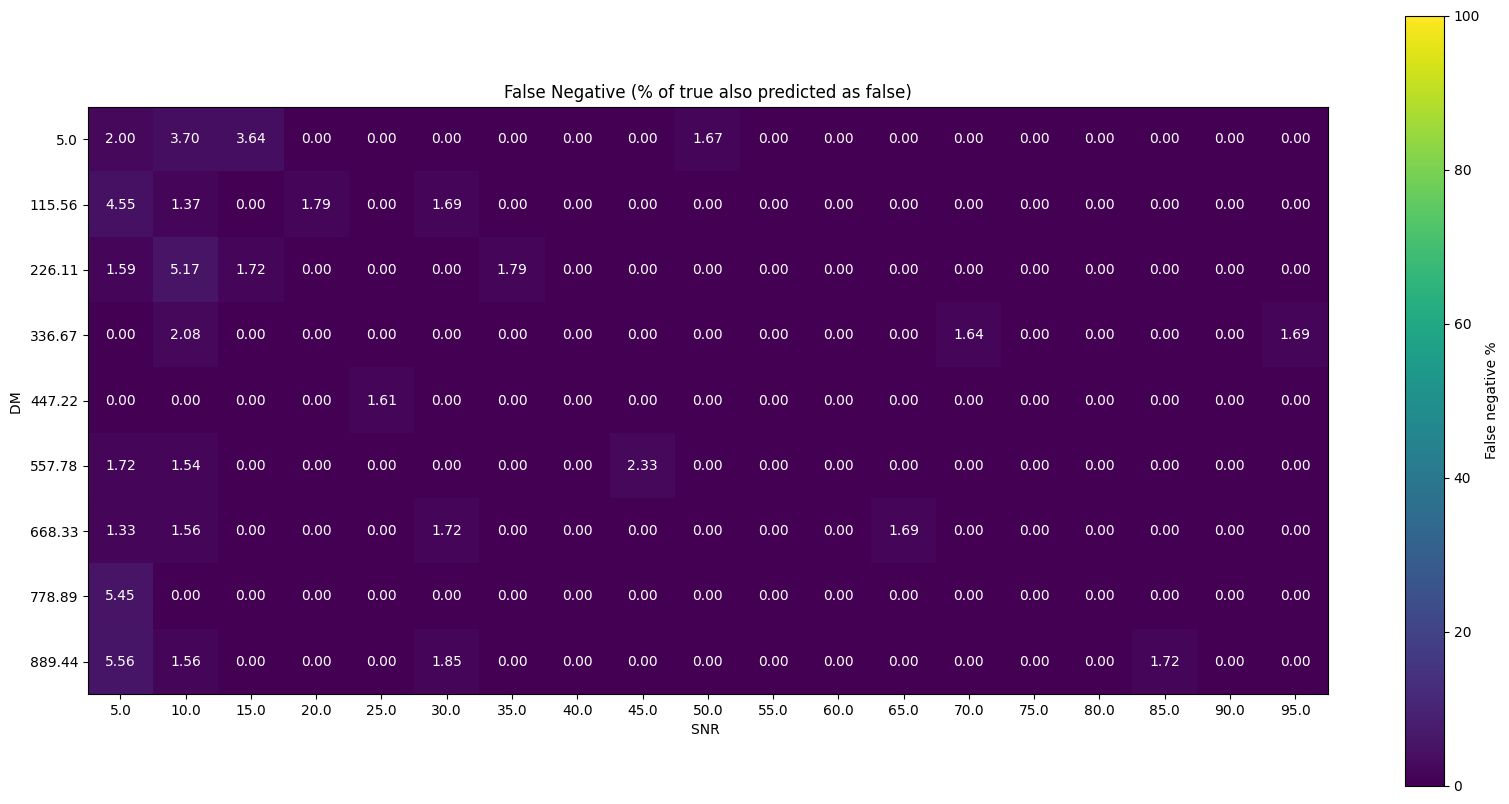

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(recall_matrix, interpolation='nearest', vmin=0, vmax=100)

# Add text annotations to each cell
for i in range(recall_matrix.shape[0]):
    for j in range(recall_matrix.shape[1]):
        plt.text(j, i, f'{recall_matrix[i, j]:.2f}', ha='center', va='center', color='white')

plt.colorbar( label='False negative %')
plt.xlabel('SNR ')
plt.ylabel('DM ')


xtick_positions = np.arange(0, recall_matrix.shape[1], 1)  # Custom x tick positions
ytick_positions = np.arange(0, recall_matrix.shape[0], 1)  # Custom y tick positions
xtick_labels =  snr_ranges[:-1]# Custom x tick labels
for i in range(len(xtick_labels)):
    xtick_labels[i] = round(xtick_labels[i], 2)

ytick_labels = dm_ranges[:-1]  # Custom y tick labels
for i in range(len(ytick_labels)):
    ytick_labels[i] = round(ytick_labels[i], 2)


plt.xticks(ticks=xtick_positions, labels=xtick_labels)
plt.yticks(ticks=ytick_positions, labels=ytick_labels)

plt.title('False Negative (% of true also predicted as false)')
plt.savefig("FN_dm_snr.pdf", format='pdf')

In [13]:
from tqdm import tqdm
# eval
model.training
val_loss = 0.0
correct_valid = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in testloader:
        inputs, labels = images.to(device), labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_true.extend(labels[0].cpu().numpy().tolist())

AUC: 0.994


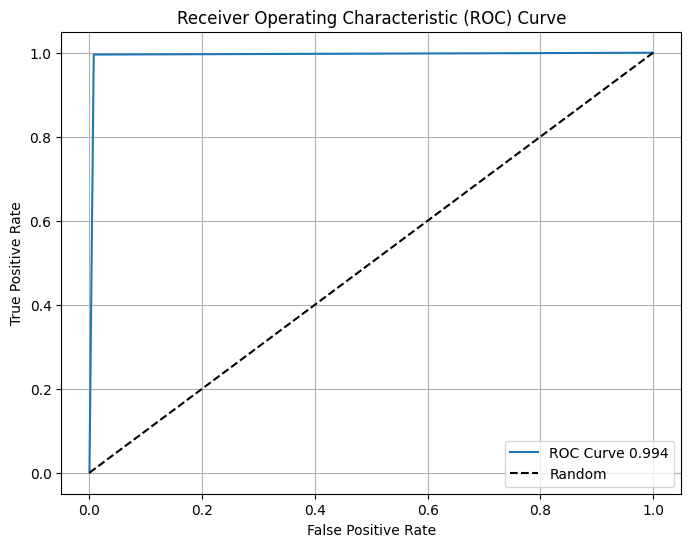

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Example data (replace with your actual data)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print("AUC:", auc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve '+str(round(auc, 4)))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

[[9924   76]
 [  44 9956]]


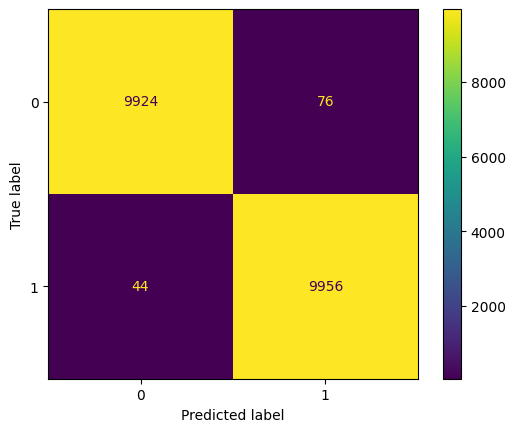

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [16]:
# Extract the number of False Positives (FP) and True Negatives (TN)
TN = cm[-1, -1]  # Bottom right element (True Negatives)
FP = cm[:-1, -1].sum()  # Sum of last column (excluding bottom right)

# Calculate FPR using the formula
FPR = FP / (FP + TN)

# Optional: Multiply by 100 for percentage
FPR_percentage = FPR * 100

# Print the FPR
print("False Positive Rate (FPR):", FPR)
print("False Positive Rate (FPR in percentage):", FPR_percentage, "%")

False Positive Rate (FPR): 0.007575757575757576
False Positive Rate (FPR in percentage): 0.7575757575757576 %


In [17]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(y_true, y_pred)

print("F1 score:", f1)

F1 score: 0.9940095846645367


In [18]:
accuracy_freq = np.zeros_like(freq_ranges)
fp_freq = np.zeros_like(freq_ranges)
for i in range(1, freq_ranges.shape[0]):
    end_f = freq_ranges[i]
    start_f = freq_ranges[i-1]
    
    f_index = np.where( np.logical_and(end_f > np.array(results['freq']), start_f<np.array(results['freq'])))[0].tolist()
    y_pred = np.array(results['pred'])[f_index]
    y_true = np.array(results['true'])[f_index]
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # Extract the number of False Positives (FP) and True Negatives (TN)
    TN = cm[-1, -1]  # Bottom right element (True Negatives)
    FP = cm[:-1, -1].sum()  # Sum of last column (excluding bottom right)
    # Calculate FPR using the formula
    if FP + TN != 0:
        FPR = FP / (FP + TN)
    else:
        FPR = 0
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_freq[i-1] = accuracy
    fp_freq[i-1] = FPR

Text(0.5, 0, 'Frequency [MHz]')

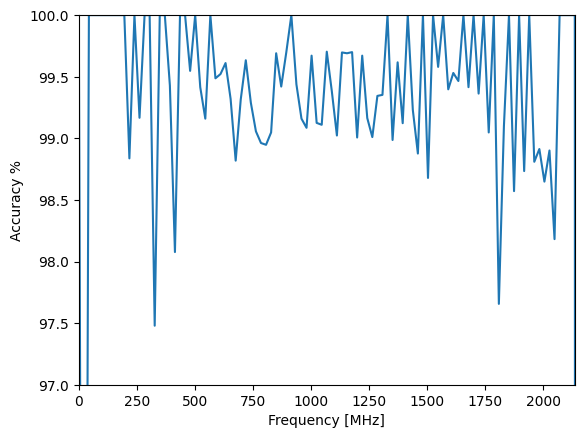

In [19]:
plt.plot(freq_ranges, accuracy_freq*100)
plt.xlim(0, freq_ranges[-2])
plt.ylim(97, 100)
plt.ylabel('Accuracy %')
plt.xlabel('Frequency [MHz]')

In [20]:
fp_freq

array([0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02      , 0.        , 0.        , 0.        , 0.        ,
       0.01754386, 0.        , 0.        , 0.01075269, 0.01149425,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01020408, 0.        , 0.00689655,
       0.        , 0.0212766 , 0.        , 0.        , 0.00662252,
       0.00641026, 0.01851852, 0.01324503, 0.01351351, 0.        ,
       0.01298701, 0.00574713, 0.        , 0.00595238, 0.01612903,
       0.01129944, 0.        , 0.01156069, 0.01219512, 0.00555556,
       0.00617284, 0.02013423, 0.00613497, 0.        , 0.00564972,
       0.        , 0.        , 0.01648352, 0.01298701, 0.00689655,
       0.01282051, 0.        , 0.02054795, 0.00757576, 0.0078125 ,
       0.        , 0.01639344, 0.02173913, 0.        , 0.00909091,
       0.        , 0.00909091, 0.        , 0.01315789, 0.     

Text(0.5, 0, 'Frequency [MHz]')

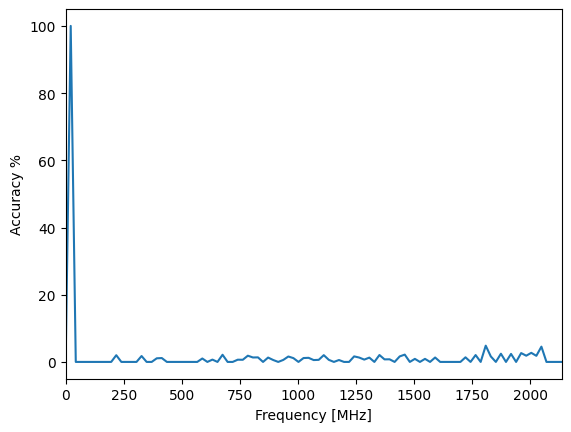

In [21]:
plt.plot(freq_ranges, fp_freq*100)
plt.xlim(0, freq_ranges[-2])
# plt.ylim(97, 100)
plt.ylabel('Accuracy %')
plt.xlabel('Frequency [MHz]')

/tmp/ipykernel_351828/726731163.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(test_dataset[i][0][0,:,:]), aspect = 10)


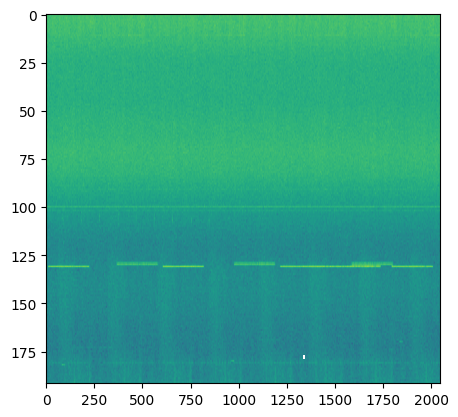

In [22]:
plt.imshow(np.log10(test_dataset[i][0][0,:,:]), aspect = 10)


In [23]:
model.eval()
i = 2
print(model(torch.tensor(np.expand_dims(test_dataset[i][0][:,:,:], axis = 0))))
print(test_dataset[i][1])

tensor([[ 4.4230, -4.4780]], device='cuda:0', grad_fn=<GatherBackward>)
(0, 0, 1491, 0)
